In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 100)
from pandas import json_normalize
import numpy as np
import os
import csv
import multiprocessing as mp
import re
from datetime import datetime
# import helper as h
# import AQDataHelper as aqh
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib
import geopy


import warnings
warnings.filterwarnings("ignore")


In [2]:
df_articles = pd.read_csv("../dataset/News_articles_dataset/News_articles_dataset.csv.gz")
df_articles

,media,date,url,heading,content,other.author,other.top_image,other.category,city,year,state,district,matches
0,TOI,2010-01-01,http://timesofindia.indiatimes.com//city/mumbai/Mumbai-celebrates-a-cool-New-Years-Eve-at-13-4C/...,Mumbai celebrates a cool New Year's Eve at 13.4फ्C,MUMBAI: The city witnessed its lowest temperature of the season on New Year ’s Eve when the merc...,"TNN / Jan 1, 2010, 01:47 IST","https://static.toiimg.com/thumb/msid-47529300,width-1070,height-580,imgsize-110164,resizemode-75...",NaN,mumbai,2010.0,maharashtra,mumbai suburban,{'smog': 3.0}
1,TOI,2010-01-02,http://timesofindia.indiatimes.com//city/lucknow/Dense-fog-leads-to-tripping-of-power-lines/arti...,Dense fog leads to tripping of power lines,LUCKNOW: The UP Power Corporation Limited is keeping its fingers crossed for Saturday with the s...,"TNN / Jan 2, 2010, 06:40 IST","https://static.toiimg.com/thumb/msid-47529300,width-1070,height-580,imgsize-110164,resizemode-75...",NaN,lucknow,2010.0,uttar pradesh,lucknow,{'air pollutants': 2.0}
2,TOI,2010-01-09,http://timesofindia.indiatimes.com//city/chennai/City-has-high-levels-of-smog-forming-ozone/arti...,City has high levels of smog-forming ozone,CHENNAI: Dangerous levels of ground-level ozone that causes respiratory ailments could be envelo...,"Bhama Devi Ravi / TNN / Jan 9, 2010, 00:37 IST","https://static.toiimg.com/thumb/msid-47529300,width-1070,height-580,imgsize-110164,resizemode-75...",NaN,chennai,2010.0,tamil nadu,chennai,"{'ozone': 9.0, 'smog': 4.0}"
3,TOI,2010-01-11,http://timesofindia.indiatimes.com//city/jaipur/Woman-four-kids-in-hospital-after-inhaling-smoke...,"Woman, four kids in hospital after inhaling smoke",JAIPUR: A woman and her four kids were admitted to a city hospital in a serious condition after ...,"TNN / Jan 11, 2010, 01:56 IST","https://static.toiimg.com/thumb/msid-47529300,width-1070,height-580,imgsize-110164,resizemode-75...",NaN,jaipur,2010.0,rajasthan,jaipur,{'carbon monoxide': 1.0}
4,TOI,2010-01-13,http://timesofindia.indiatimes.com//city/chennai/Pollution-high-on-Bhogi-eve-Study/articleshow/5...,Pollution high on Bhogi eve: Study,"CHENNAI: By the time you get to read this, the Bhogi pollutants may have enveloped the city, but...","Bhama Devi Ravi / TNN / Jan 13, 2010, 04:23 IST","https://static.toiimg.com/thumb/msid-47529300,width-1070,height-580,imgsize-110164,resizemode-75...",NaN,chennai,2010.0,tamil nadu,chennai,"{'air quality': 1.0, 'carbon monoxide': 1.0, 'ozone': 1.0, 'so2': 1.0}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17369,Hindu,2021-05-16,https://www.thehindu.com/news/national/andhra-pradesh/naval-dockyard-teams-repair-two-oxygen-pla...,Naval Dockyard teams repair two oxygen plants in Nellore and Srikalahasti,Oxygen supply gets a big boost with this in the State during the pandemic\n\nTeams from the Nava...,SpecialCorrespondent,https://www.thehindu.com/news/national/andhra-pradesh/fvjzld/article34572702.ece/ALTERNATES/LAND...,andhra pradesh,visakhapatnam,NaN,andhra pradesh,visakhapatnam,{'carbon monoxide': 2.0}
17370,Hindu,2021-05-24,https://www.thehindu.com/news/national/kerala/greens-call-for-a-relook-into-silverline-implement...,Greens call for a relook into SilverLine implementation,"The Kerala Paristhithi Aikya Vedi, a forum of environmentalists, has urged Chief Minister Pinara...",SpecialCorrespondent,https://www.thehindu.com/static/theme/default/base/img/og-image.jpg,kerala,thiruvananthapuram,NaN,kerala,thiruvananthapuram,{'air pollution': 1.0}
17371,Hindu,2021-05-25,https://www.thehindu.com/news/national/karnataka/cftris-ozone-based-air-disinfection-system-to-c...,CFTRI’s ozone-based air disinfection system to combat droplet infections,The CSIR-Central Food Technological Research Institute (CFTRI) in Mysuru has come up with an ozo...,LaiqhAKhan,https://www.thehindu.com/sci-tech/science/wsmdd0/article33283019.ece/ALTERNATES/LANDSCAPE_615/CF...,karnataka,mysuru,NaN,karnataka,mysuru,{'ozone': 9.0}
17372,Hindu,2021-05-28,https://www.thehindu

In [3]:
#load PM2.5 data 2010-2019 (cpcb)
root_path = "../PMdataset/"
df_daily_city_stn = pd.read_csv(root_path+"pm2.5_allcities_groupby_date_city_station_2010_19.csv",index_col=0)
df_daily_city = pd.read_csv(root_path+"pm2.5_allcities_groupby_date_city_2010_19.csv",index_col=0)
#df_daily_city = df_daily_city.groupby(["From Date","city"]).mean().reset_index()
df_daily_city

,Unnamed: 0,From Date,city,WS,WD,Gust,Variance,AT,RH,SR,BP,PPAccum,Power,PM10,PM2_5,NO,NO2,NOx,CO,CO2,Ozone,BlackCarbon,Benzene,Toluene,Eth-Benzene,Xylene,CH4,NMHC,VWS,THC,NH3,SO2,Temp,MP-Xylene,RF,RackTemp,P_Xylene,O Xylene,ETH,SPM,AP,MH,readings_in_day,total_stations,active_stations,state
0,0,2010-01-01,Agra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0,Uttar Pradesh
1,1,2010-01-01,Ahmedabad,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0,Gujarat
2,2,2010-01-01,Ambala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0,Haryana
3,3,2010-01-01,Ankleshwar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0,Gujarat
4,4,2010-01-01,Bahadurgarh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0,Haryana
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202192,202192,2019-04-30,Udaipur,1.017579,253.649263,NaN,NaN,NaN,17.871263,192.898000,757.183158,NaN,NaN,87.814737,34.304255,13.917158,19.854526,33.771684,0.734835,NaN,38.070213,NaN,1.563936,NaN,4.092842,NaN,NaN,NaN,NaN,NaN,12.120947,12.064725,33.071053,1.188842,0.0,NaN,NaN,3.700211,NaN,NaN,NaN,NaN,94.0,1,1,Rajasthan
202193,202193,2019-04-30,Ujjain,4.636842,255.042105,NaN,NaN,36.660000,18.252632,161.242105,NaN,NaN,NaN,147.452632,40.126316,NaN,8.891011,5.250562,0.819535,NaN,78.206522,NaN,0.000000,0.620000,0.000000,NaN,NaN,NaN,NaN,NaN,19.031461,8.647059,31.801075,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.0,1,1,Madhya Pradesh
202194,202194,2019-04-30,Varanasi,0.801053,180.757895,NaN,NaN,33.582105,23.600000,80.157895,745.378947,NaN,NaN,331.126761,131.732394,51.202360,104.323370,74.652174,0.860652,NaN,76.047692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.522105,NaN,NaN,37.748652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.0,1,1,Uttar Pradesh
202195,202195,2019-04-30,Vijayawada,0.519041,221.018904,NaN,NaN,37.019178,55.307671,228.706154,749.476301,NaN,NaN,50.119577,20.220000,6.365139,14.738356,21.004658,NaN,NaN,NaN,NaN,0.996849,1.870137,0.057397,NaN,NaN,NaN,5.000000,NaN,5.329589,6.234658,NaN,0.734110,0.0,NaN,NaN,1.899589,NaN,NaN,NaN,NaN,67.0,1,1,Andhra Pradesh


In [4]:
df_ip = df_daily_city
city_state_dict = dict(zip(df_ip["city"].values,df_ip["state"].values))
len(city_state_dict), city_state_dict

(101,
 {'Agra': 'Uttar Pradesh',
  'Ahmedabad': 'Gujarat',
  'Ambala ': 'Haryana',
  'Ankleshwar': 'Gujarat',
  'Bahadurgarh ': 'Haryana',
  'Ballabgarh': 'Haryana',
  'Bengaluru': 'Karnataka',
  'Bhiwani': 'Haryana',
  'Chennai': 'Tamil Nadu',
  'Damoh': 'Madhya Pradesh',
  'Delhi': 'Delhi',
  'Dharuhera': 'Haryana',
  'Faridabad': 'Haryana',
  'Fatehabad ': 'Haryana',
  'Gandhinagar': 'Gujarat',
  'Ghaziabad': 'Uttar Pradesh',
  'Gurugram': 'Haryana',
  'Guwahati': 'Assam',
  'Hapur': 'Uttar Pradesh',
  'Hisar': 'Haryana',
  'Hyderabad': 'Telangana',
  'Jind': 'Haryana',
  'Kaithal': 'Haryana',
  'Kanpur': 'Uttar Pradesh',
  'Karnal': 'Haryana',
  'Kurukshetra ': 'Haryana',
  'Loni Dehat': 'Uttar Pradesh',
  'Lucknow': 'Uttar Pradesh',
  'Maihar': 'Madhya Pradesh',
  'Mandikhera': 'Haryana',
  'Manesar ': 'Haryana',
  'Mumbai': 'Maharashtra',
  'Nagpur': 'Maharashtra',
  'Narnaul': 'Haryana',
  'Navi Mumbai': 'Maharashtra',
  'Palwal ': 'Haryana',
  'Panipat': 'Haryana',
  'Pune': 'M

In [5]:
#load OpenAQ data 2019-2021
root_path = "../PMdataset/"
df_daily_city_stn_oq = pd.read_csv(root_path+"pm2.5_allcities_groupby_date_city_station_2019_21_openaq.csv",index_col=0)
df_daily_city_oq = pd.read_csv(root_path+"pm2.5_allcities_groupby_date_city_2019_21_openaq.csv",index_col=0)
#df_daily_city_oq = df_daily_city_oq.groupby(["From Date","city"]).mean().reset_index()
df_daily_city_oq

,From Date,city,PM2_5,readings,total_stations,active_stations
0,2019-01-18,Delhi,133.960000,2.0,1,1
2,2019-04-30,Agra,90.000000,1.0,1,1
3,2019-04-30,Ajmer,105.640000,2.0,1,1
4,2019-04-30,Amaravati,22.000000,1.0,1,1
6,2019-04-30,Amritsar,50.970000,1.0,1,1
...,...,...,...,...,...,...
75127,2021-08-01,Solapur,18.020000,69.0,1,1
75128,2021-12-03,Solapur,NaN,0.0,1,0
75129,2021-12-04,Solapur,NaN,0.0,1,0
75130,2021-12-05,Solapur,14.172069,29.0,1,1


In [6]:
#merge cpcb and openaq 
df_daily_city_merged = pd.concat([df_daily_city,df_daily_city_oq])[["From Date","city",
                                                                    "PM2_5","total_stations","active_stations","state"]]

df_daily_city_merged.city = df_daily_city_merged.city.apply(lambda x:x.strip().lower())
df_daily_city_merged["From Date"] = pd.to_datetime(df_daily_city_merged["From Date"])
df_daily_city_merged = df_daily_city_merged.groupby(["From Date","city"]).mean().reset_index()
df_daily_city_merged

,From Date,city,PM2_5,total_stations,active_stations
0,2010-01-01,agra,NaN,1.0,0.0
1,2010-01-01,ahmedabad,NaN,1.0,0.0
2,2010-01-01,ambala,NaN,1.0,0.0
3,2010-01-01,ankleshwar,NaN,1.0,0.0
4,2010-01-01,bahadurgarh,NaN,1.0,0.0
...,...,...,...,...,...
254058,2021-08-01,solapur,18.020000,1.0,1.0
254059,2021-12-03,solapur,NaN,1.0,0.0
254060,2021-12-04,solapur,NaN,1.0,0.0
254061,2021-12-05,solapur,14.172069,1.0,1.0


In [7]:
df_daily_city_merged["state"] = df_daily_city_merged["city"].apply(lambda x:city_state_dict[x.capitalize()].lower() if x.capitalize() in city_state_dict else np.nan)
df_daily_city_merged

,From Date,city,PM2_5,total_stations,active_stations,state
0,2010-01-01,agra,NaN,1.0,0.0,uttar pradesh
1,2010-01-01,ahmedabad,NaN,1.0,0.0,gujarat
2,2010-01-01,ambala,NaN,1.0,0.0,NaN
3,2010-01-01,ankleshwar,NaN,1.0,0.0,gujarat
4,2010-01-01,bahadurgarh,NaN,1.0,0.0,NaN
...,...,...,...,...,...,...
254058,2021-08-01,solapur,18.020000,1.0,1.0,maharashtra
254059,2021-12-03,solapur,NaN,1.0,0.0,maharashtra
254060,2021-12-04,solapur,NaN,1.0,0.0,maharashtra
254061,2021-12-05,solapur,14.172069,1.0,1.0,maharashtra


In [8]:
df_daily_city_merged.state.unique()

array(['uttar pradesh', 'gujarat', nan, 'haryana', 'karnataka',
       'tamil nadu', 'madhya pradesh', 'delhi', 'assam', 'telangana',
       'maharashtra', 'bihar', 'west bengal', 'rajasthan',
       'andhra pradesh', 'punjab', 'odisha', 'jharkhand', 'kerala'],
      dtype=object)

# Delhi - Articles vs PM2.5

In [9]:
def format_axes(ax,twinx=False,SPINE_COLOR = "gray"):
    
    if twinx:
        for spine in ['top']:
            ax.spines[spine].set_visible(False)

        for spine in ['left', 'bottom', 'right']:
            ax.spines[spine].set_color(SPINE_COLOR)
            ax.spines[spine].set_linewidth(0.5)
        
    else:
        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)

        for spine in ['left', 'bottom']:
            ax.spines[spine].set_color(SPINE_COLOR)
            ax.spines[spine].set_linewidth(0.5)

    return ax

def latexify(fig_width=None, fig_height=None, columns=2):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.32 if columns==1 else 6.75 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': [r'\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'font.size': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)

In [10]:
def add_month_year_column(which_df):
    #make month column from date
    which_df["month"] = which_df.apply(lambda x:f'{x["date"].year}-{x["date"].month}',axis=1)

    #make year column from date
    which_df["year"] = which_df.apply(lambda x:f'{x["date"].year}',axis=1)
    
    return which_df


def get_article_count_df(article_df, start_date = datetime(2010,1,1).date(), end_date = datetime(2021,5,30).date()):
    '''
    count articles per day by applying group by date
    returns dataframe
    '''
    
    article_count = article_df.groupby(by="date")["heading"].count()
    
    #range of all date
    date_idx = pd.date_range(start_date, end_date)
    
    #get articles from specific range    
    article_count = article_count[start_date:end_date]

    #fill missing dates
    article_count = article_count.reindex(date_idx,fill_value=0)

    article_count =  article_count.reset_index()
    article_count.columns = ["date","count"]
    
    #add month & year columns
    article_count = add_month_year_column(article_count)
    return article_count

def filter_cities(which_df,allowed_cities):
    '''
    gives only those rows of dataframe which "city" columns
    contains given cities
    allowed cities can be one city or list of cities
    '''
    if type(allowed_cities) == str:
        allowed_cities = [allowed_cities]
    #remove NA values in city
    which_df = which_df.dropna(subset=["city"])

    #city can be list or str
    filtered_df = which_df[which_df["city"].apply(lambda city: True in [each.lower().strip() in city for each in allowed_cities] if type(city) == str or type(city) == list else False)]
    return filtered_df

In [11]:
%config Completer.use_jedi = False


5296


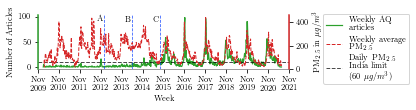

In [12]:
latexify(fig_width=4.5,fig_height=1)

fig,ax = plt.subplots()
plts = []

pm_color = "tab:red"
article_color = "tab:green"
#trend_color = "tab:green"

############################################################################################
city = "delhi"

start_date = datetime(2010,2,1)
end_date = datetime(2021,6,21)

df_articles["date"] = pd.to_datetime(df_articles["date"])
df_a = filter_cities(df_articles,[city])
print(len(df_a))
df_a = get_article_count_df(df_a,start_date=start_date,end_date=end_date)
#df_a = df_a.resample("7D",on="date").reset_index()

df_a = df_a.resample("7D",on="date").sum().reset_index()

x2 = df_a["date"]
y2 = df_a["count"]
    
twin = []

plt2 = ax.plot(x2,y2,label = "Weekly AQ\narticles",linewidth=1.2,color=article_color)
ax.set_ylabel("Number of Articles")
ax.set_xlabel("Week")

ax2 = ax.twinx()
twin.append(ax2)
format_axes(ax,twinx=True)
#ax.set_yticks(np.arange(0,111,55))
#format_axes(ax_t,twinx=True);


plts.append(plt2[0])
ax_t = ax2

#plot PM2.5 data
city_df = df_daily_city_merged[df_daily_city_merged.city == city]
city_df["From Date"] = pd.to_datetime(city_df["From Date"])

which_df = city_df
which_df = which_df[(which_df["From Date"] >= start_date) & (which_df["From Date"] <= end_date)]
which_df = which_df.resample("7D",on="From Date").mean().reset_index()
keyword = "PM2_5"

#total_count = which_df[keyword].sum()
x1, y1 = which_df["From Date"], which_df[keyword]

plt1 = ax_t.plot(x1,y1,"--",label = "Weekly average\nPM$_{2.5}$",color=pm_color,linewidth=1)
ax_t.set_ylabel("PM$_{2.5}$ in $\mu g/m^3$")



#set india limit ***************************************
plt_hline = ax_t.hlines(60,datetime(2009,11,1),datetime(2021,11,1),
            linestyles="dashed",alpha=0.7,color="k",label="Daily PM$_{2.5}$\nIndia limit\n(60 $\mu g/m^3 $)",linewidth=1)

#ax_t.set_xlabel("Day")
#ax_t.set_title("Delhi")

plts.append(plt1[0])
plts.append(plt_hline)
#india limit ***************************************


y_indicator = 90
lineWidth = 0.8

#Us embassy started posting India air pollution data
openaq = datetime(2013,1,1)
indicator_1 = ax.axvline(x=openaq, linestyle='dashed', alpha=0.8,  color='#0037ff',linewidth = lineWidth, label="A") #: US embassy\reporting
delta = pd.Timedelta(days=130)
#ax.annotate("OpenAQ\nwebsite\nlauched",xy = (openaq+delta,100),)
ax.annotate("A",xy = (openaq-delta,y_indicator))
#plts.append(indicator_1)


#WHO updated database
openaq = datetime(2014,5,7)
indicator_2 = ax.axvline(x=openaq, linestyle='dashed', alpha=0.8,  color='#0037ff',linewidth = lineWidth, label="B") #Delhi became \nmost polluted \ncity in the world
delta = pd.Timedelta(days=130)
#ax.annotate("New Delhi became\nmost polluted \ncity worldwise",xy = (openaq-delta,100))
ax.annotate("B",xy = (openaq-delta,y_indicator))
#plts.append(indicator_2)





#OpenAQ started posting air pollution data
openaq = datetime(2015,9,1)
indicator_1 = ax.axvline(x=openaq, linestyle='dashed', alpha=0.8,  color='#0037ff',linewidth = lineWidth ,label="C")# OpenAQ\nwebsite lauched"
delta = pd.Timedelta(days=120)
#ax.annotate("OpenAQ\nwebsite\nlauched",xy = (openaq+delta,100),)
ax.annotate("C",xy = (openaq-delta,y_indicator))
#plts.append(indicator_1)




#set format of date
date_form = DateFormatter("%b\n%Y")


ax_t.xaxis.set_major_formatter(date_form)

#make interval of n months
ax_t.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax_t.tick_params(axis="x",rotation=0)
ax.set_xlim(datetime(2009,11,1),datetime(2021,11,1))



labs = [l.get_label() for l in plts] + [indicator_1.get_label()]
plt.legend(plts, labs, bbox_to_anchor=(1.12, 1.1))


format_axes(ax_t,twinx=True);
ax_t.spines['right'].set_color(pm_color)
ax_t.spines['right'].set_linewidth(1.5)

ax_t.spines['left'].set_color(article_color)
ax_t.spines['left'].set_linewidth(1.5)


In [65]:
fig.savefig("../figures/fig5_timeseries_of_aq_articles_delhi_with_two_indicators_embassy_added.pdf",bbox_inches="tight")